In [1]:
# import libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import numpy as np


from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)

In [6]:
# Displace the unique values of the Zr, C and Fe compositions, 
# the initial data collection contains some < signs or ppm, bal, we want to check if these columns have this sign.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.09 0.21 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 90.174 96.828
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [7]:
# Remove the data with <, ppm and bal text in these there columns. 
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [8]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.09 0.21 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 90.174 96.828
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [9]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [10]:
# Get only SS316 data points
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))]

In [11]:
# Drop the columns that don't have  enough data records
tensile_df = tensile_df.drop(columns=[ 'Treatment', 'Irradiation Dose (mdpa)', 'Irradiation Temperature (C)','Irradiation Time (h)', 'Fillet Radius (mm)',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)',
                                        ])

In [12]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 21 to 1472
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1008 non-null   int64  
 1   Material                         1008 non-null   object 
 2   Material Group                   1008 non-null   object 
 3   C (wt.%)                         1008 non-null   float64
 4   Si (wt.%)                        1008 non-null   float64
 5   Mn (wt.%)                        1008 non-null   float64
 6   P (wt.%)                         1008 non-null   float64
 7   S (wt.%)                         1008 non-null   float64
 8   Ni (wt.%)                        1008 non-null   float64
 9   Cr (wt.%)                        1008 non-null   float64
 10  Mo (wt.%)                        1008 non-null   float64
 11  Al (wt.%)                        1008 non-null   float64
 12  N (wt.%)                

In [13]:
# Check the how many data points for each material.
tensile_df['Material'].value_counts()

Material
SS316      527
JPCA       186
SS316-A     95
SS316-B     72
SS316-C     71
SS316L      57
Name: count, dtype: int64

In [14]:
# remove SS316L
tensile_df = tensile_df[tensile_df['Material'] != 'SS316L']

In [15]:
# Check the how many data points for each material after removing the ss316L data.
tensile_df['Material'].value_counts()

Material
SS316      527
JPCA       186
SS316-A     95
SS316-B     72
SS316-C     71
Name: count, dtype: int64

In [16]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 57 to 1472
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        951 non-null    int64  
 1   Material                         951 non-null    object 
 2   Material Group                   951 non-null    object 
 3   C (wt.%)                         951 non-null    float64
 4   Si (wt.%)                        951 non-null    float64
 5   Mn (wt.%)                        951 non-null    float64
 6   P (wt.%)                         951 non-null    float64
 7   S (wt.%)                         951 non-null    float64
 8   Ni (wt.%)                        951 non-null    float64
 9   Cr (wt.%)                        951 non-null    float64
 10  Mo (wt.%)                        951 non-null    float64
 11  Al (wt.%)                        951 non-null    float64
 12  N (wt.%)                 

In [17]:
# rename the Treatment - Three Categories column as Treatment colum
tensile_df = tensile_df.rename(columns={'Treatment – Three Categories': 'Treatment'})

In [18]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 57 to 1472
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        951 non-null    int64  
 1   Material                         951 non-null    object 
 2   Material Group                   951 non-null    object 
 3   C (wt.%)                         951 non-null    float64
 4   Si (wt.%)                        951 non-null    float64
 5   Mn (wt.%)                        951 non-null    float64
 6   P (wt.%)                         951 non-null    float64
 7   S (wt.%)                         951 non-null    float64
 8   Ni (wt.%)                        951 non-null    float64
 9   Cr (wt.%)                        951 non-null    float64
 10  Mo (wt.%)                        951 non-null    float64
 11  Al (wt.%)                        951 non-null    float64
 12  N (wt.%)                 

In [19]:
# in the Treatment column rename the entries "20% cold-worked" as "20% Cold Worked"
tensile_df['Treatment'] = tensile_df['Treatment'].replace('20% cold-worked', '20% Cold Worked')

In [20]:
# check how many data points for different specimen sizes.
tensile_df['Specimen Size'].value_counts()

Specimen Size
Sub-sized    531
Standard     420
Name: count, dtype: int64

In [21]:
# Check how many data for different gauge lenght and speicmen sizes.
tensile_df.groupby('Gauge Length (mm)')['Specimen Size'].sum()

Gauge Length (mm)
5.00     Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
7.62     Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
10.00    Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
12.70    Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
15.00    Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
18.30    Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
20.32    Sub-sizedSub-sizedSub-sizedSub-sizedSub-sizedS...
25.00    StandardStandardStandardStandardStandardStanda...
25.40    StandardStandardStandardStandardStandardStanda...
50.80    StandardStandardStandardStandardStandardStanda...
Name: Specimen Size, dtype: object

<Axes: xlabel='Gauge Length (mm)', ylabel='Yield Strength (MPa)'>

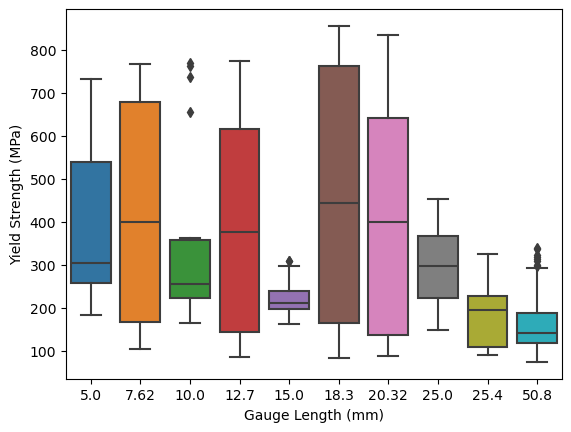

In [22]:
import seaborn as sns
# plot yield strength box plots based on gauge length
sns.boxplot(x='Gauge Length (mm)', y='Yield Strength (MPa)', data=tensile_df)

<Axes: xlabel='Gauge Length (mm)', ylabel='Yield Strength (MPa)'>

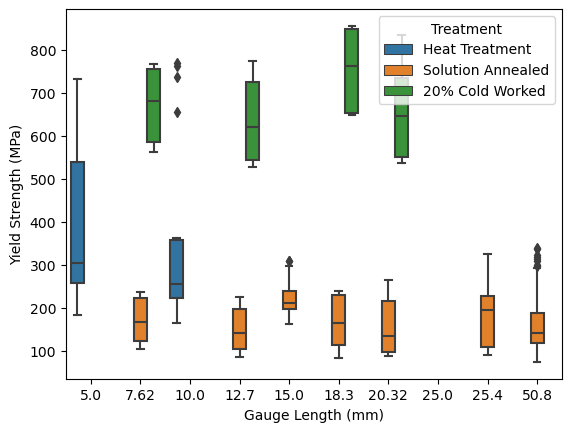

In [23]:
# plot yield strength box plots based on gauge length by treatment-three categories
sns.boxplot(x='Gauge Length (mm)', y='Yield Strength (MPa)', hue='Treatment', data=tensile_df)

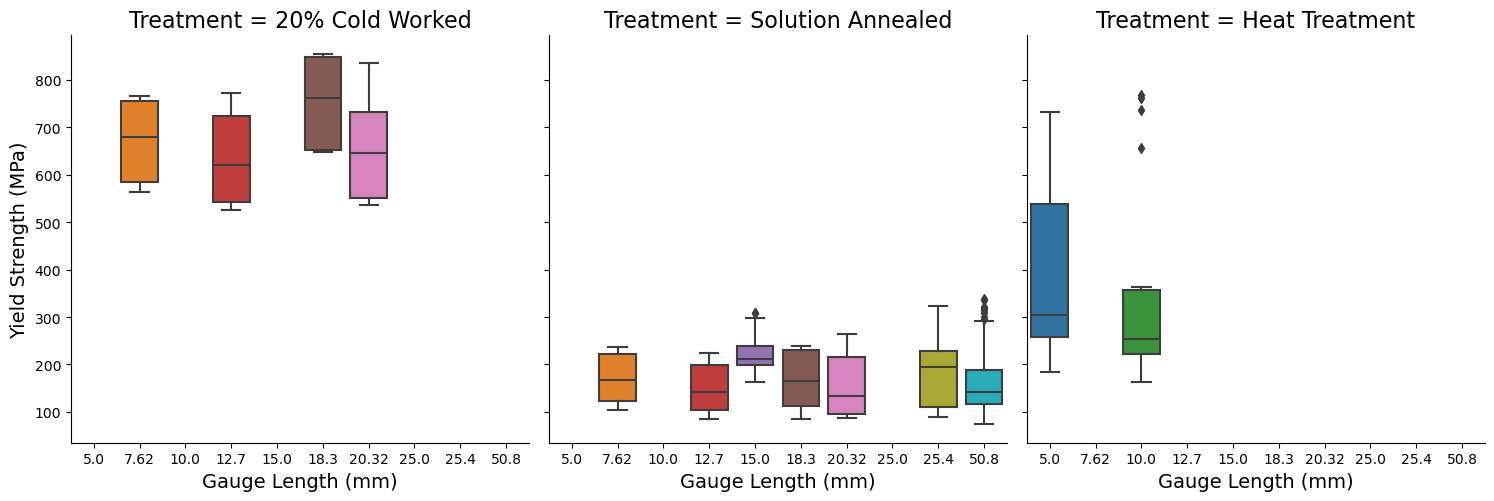

In [24]:
# plot yield strength box plots based on gauge length by treatment, create three subplots based on treatment
# Order the plots for the treatment: 20% colde worked on the right
g = sns.catplot(x='Gauge Length (mm)', y='Yield Strength (MPa)', col='Treatment', data=tensile_df, kind='box',
            palette='tab10', legend=False,  col_order=['20% Cold Worked', 'Solution Annealed', 'Heat Treatment'])
# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Gauge Length (mm)', fontsize=14)
    ax.set_ylabel('Yield Strength (MPa)', fontsize=14)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=10)
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)

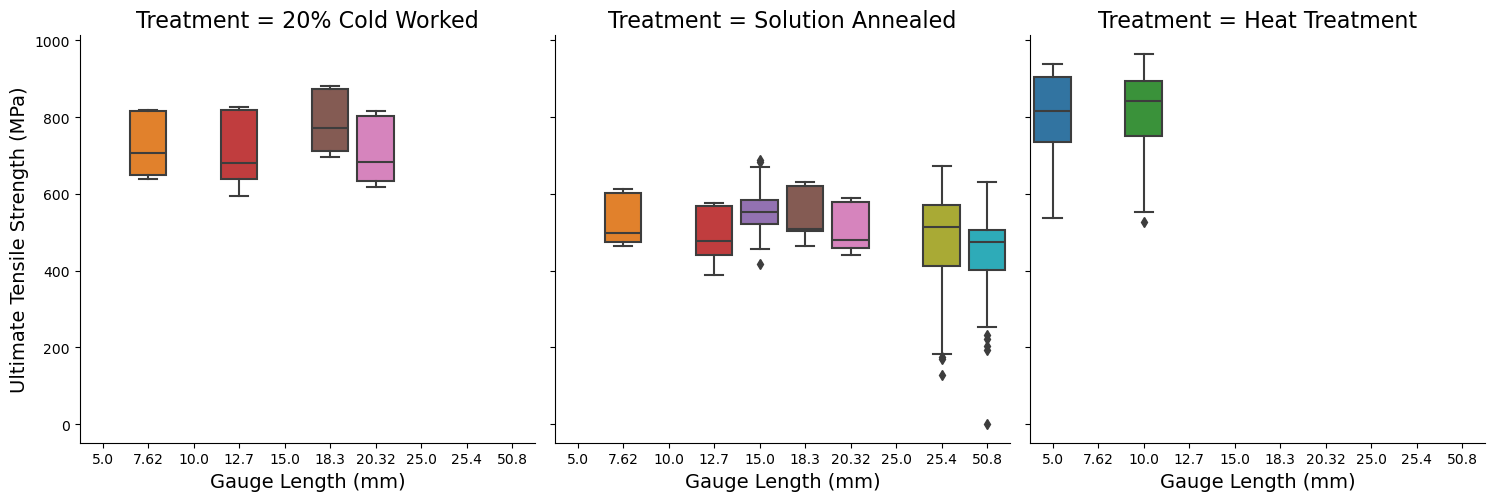

In [25]:
# plot ultimate tensile strength box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Gauge Length (mm)', y='Ultimate Tensile Strength (MPa)', col='Treatment', data=tensile_df, kind='box',
            palette='tab10', legend=False, col_order=['20% Cold Worked', 'Solution Annealed', 'Heat Treatment'])
# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Gauge Length (mm)', fontsize=14)
    ax.set_ylabel('Ultimate Tensile Strength (MPa)', fontsize=14)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=10)
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)

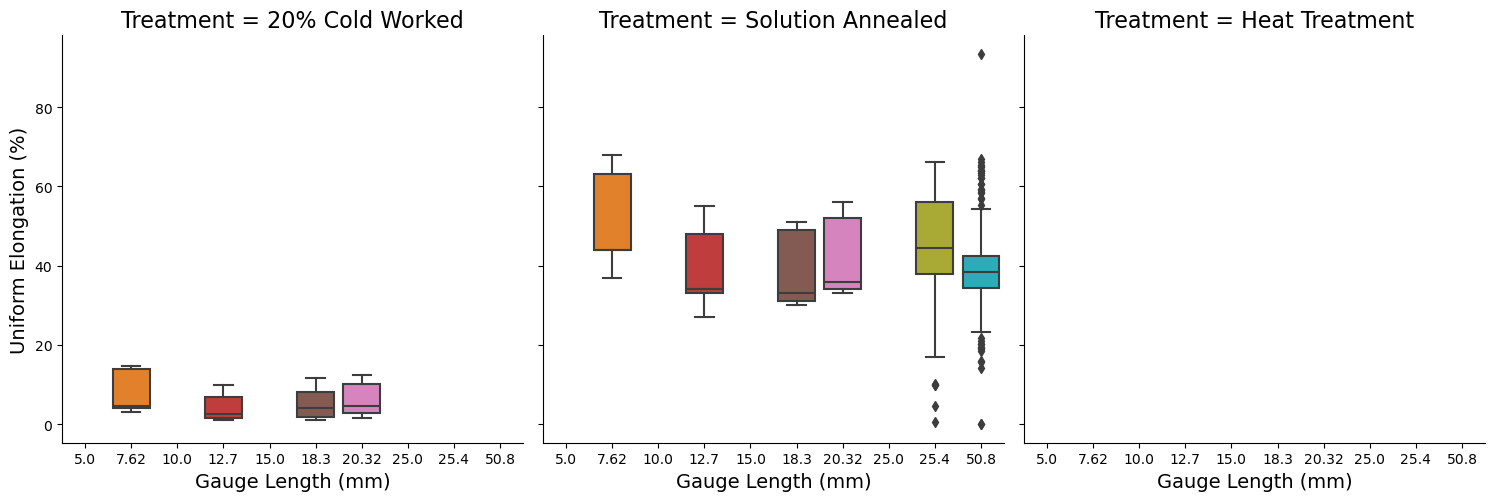

In [26]:
# plot uniform elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Gauge Length (mm)', y='Uniform Elongation (%)', col='Treatment', data=tensile_df, kind='box',
                palette='tab10', legend=False, col_order=['20% Cold Worked', 'Solution Annealed', 'Heat Treatment'])

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Gauge Length (mm)', fontsize=14)
    ax.set_ylabel('Uniform Elongation (%)', fontsize=14)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=10)
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)

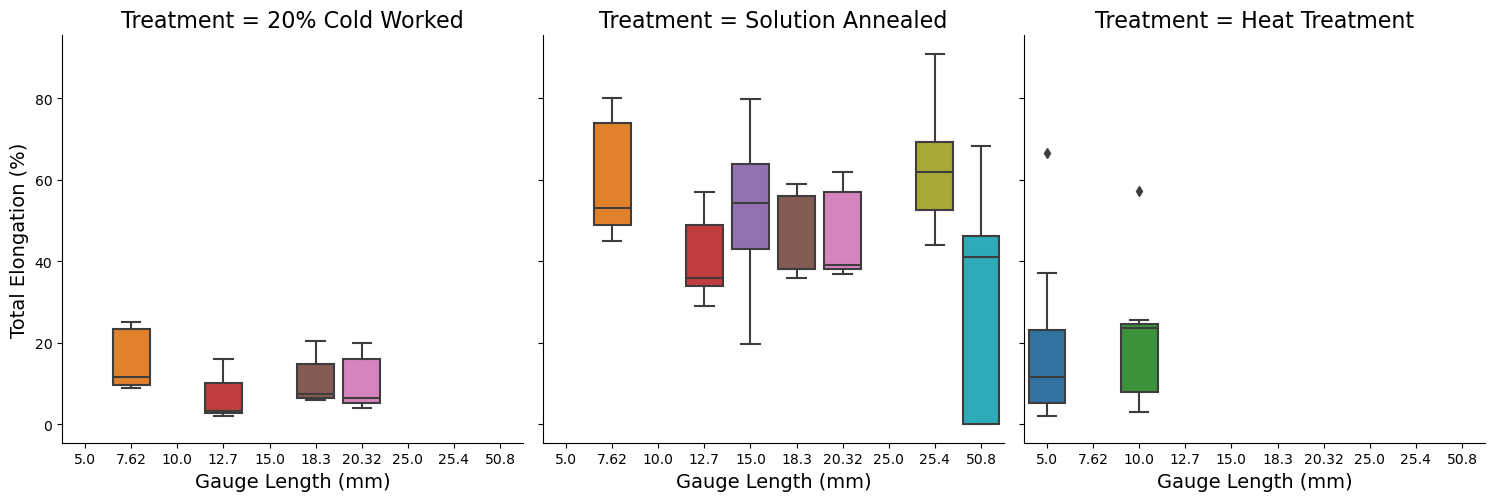

In [27]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Gauge Length (mm)', y='Total Elongation (%)', col='Treatment', data=tensile_df, kind='box',
                palette='tab10', legend=False, col_order=['20% Cold Worked', 'Solution Annealed', 'Heat Treatment'])

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Gauge Length (mm)', fontsize=14)
    ax.set_ylabel('Total Elongation (%)', fontsize=14)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=10)
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16)

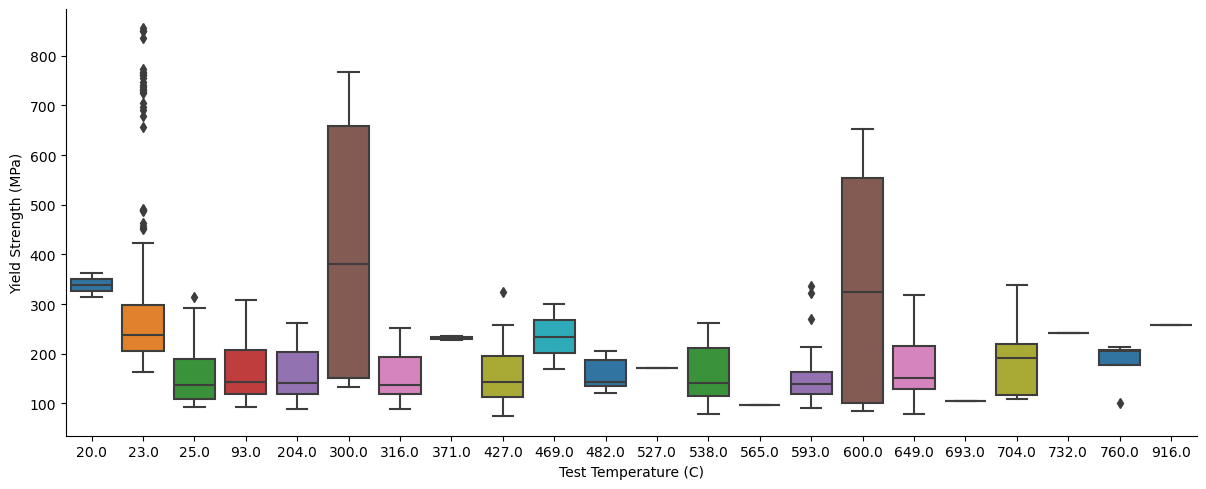

In [28]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
# increase the width of the figure, the x-axis labels are not visible
g = sns.catplot(x='Test Temperature (C)', y='Yield Strength (MPa)', data=tensile_df, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(14)

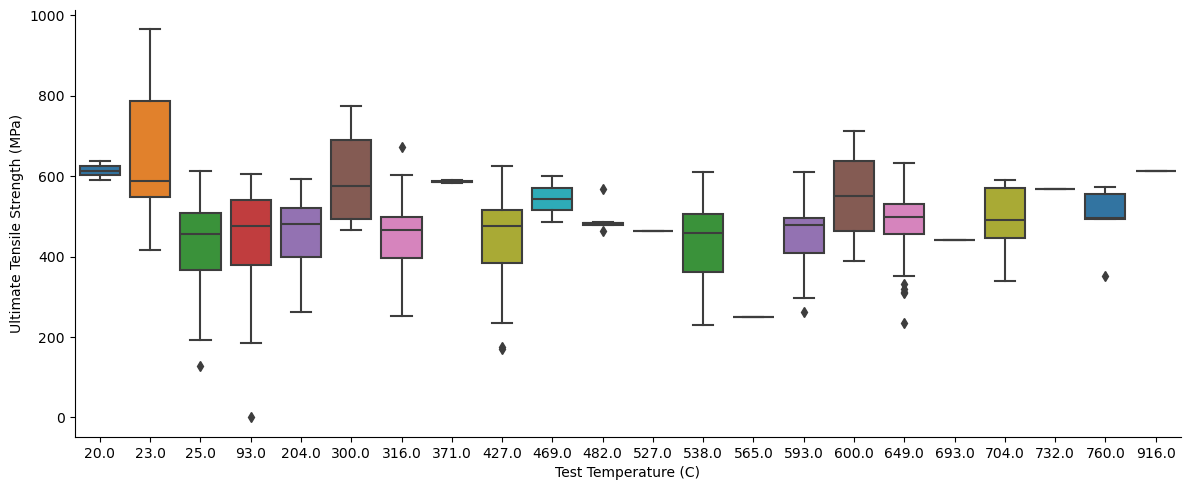

In [29]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Ultimate Tensile Strength (MPa)', data=tensile_df, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(14)

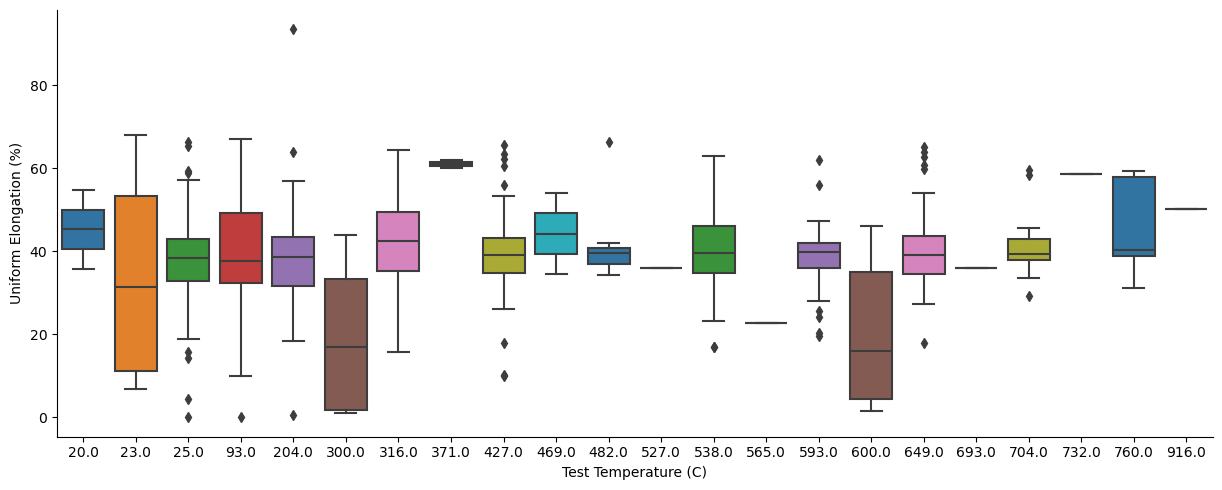

In [30]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Uniform Elongation (%)', data=tensile_df, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(14)

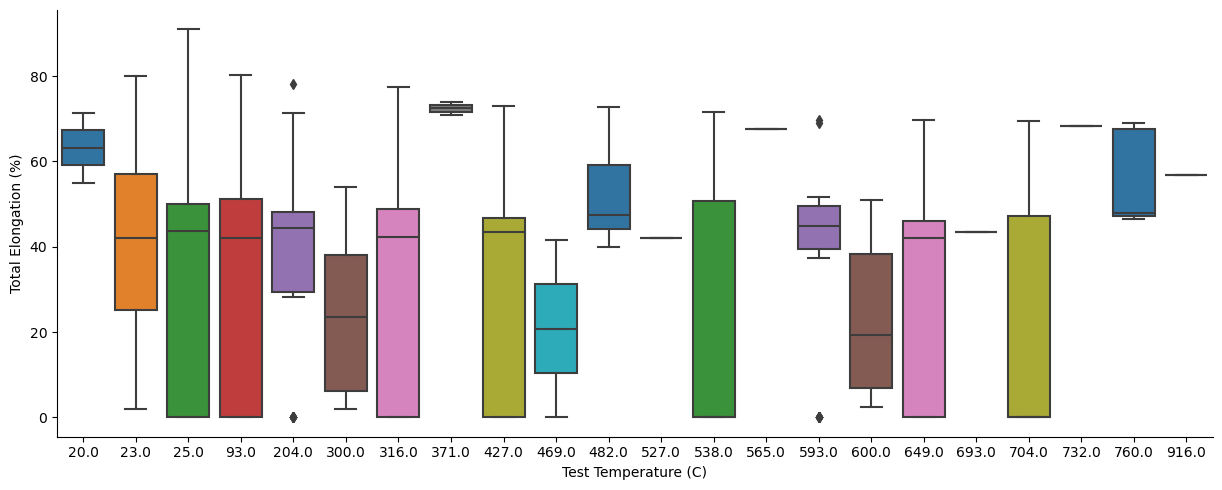

In [31]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Total Elongation (%)', data=tensile_df, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(14)

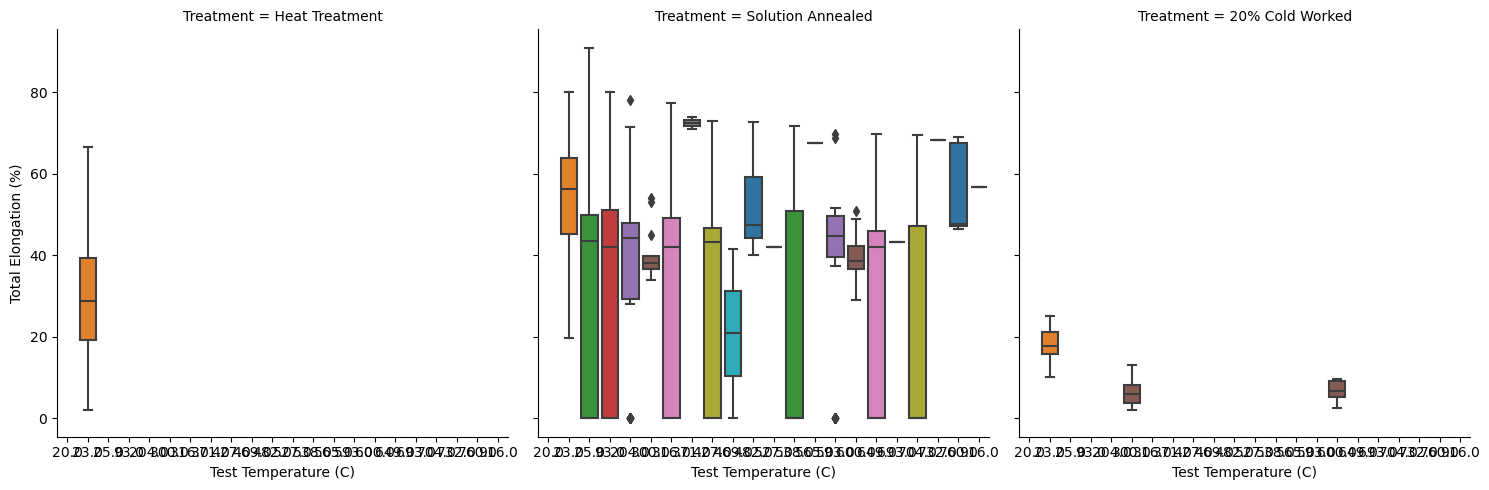

In [32]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
sns.catplot(x='Test Temperature (C)', y='Total Elongation (%)', col='Treatment', data=tensile_df, kind='box', palette='tab10', legend=False)

In [33]:
# check how many data points for different temperatures
tensile_df['Test Temperature (C)'].value_counts()

Test Temperature (C)
23.0     487
25.0      76
649.0     62
427.0     51
593.0     48
204.0     42
316.0     35
93.0      35
538.0     31
600.0     24
300.0     24
704.0     13
482.0      7
760.0      5
469.0      2
371.0      2
20.0       2
527.0      1
565.0      1
693.0      1
732.0      1
916.0      1
Name: count, dtype: int64

In [34]:
# create a new dataframe for which there is more than 10 temperature values
temp_df_temperature = tensile_df.groupby('Test Temperature (C)').filter(lambda x: len(x) > 10)

In [35]:
# remove data points with tmeperature of 25, 300, and 600
temp_df_temperature = temp_df_temperature[~temp_df_temperature['Test Temperature (C)'].isin([25, 300, 600])]

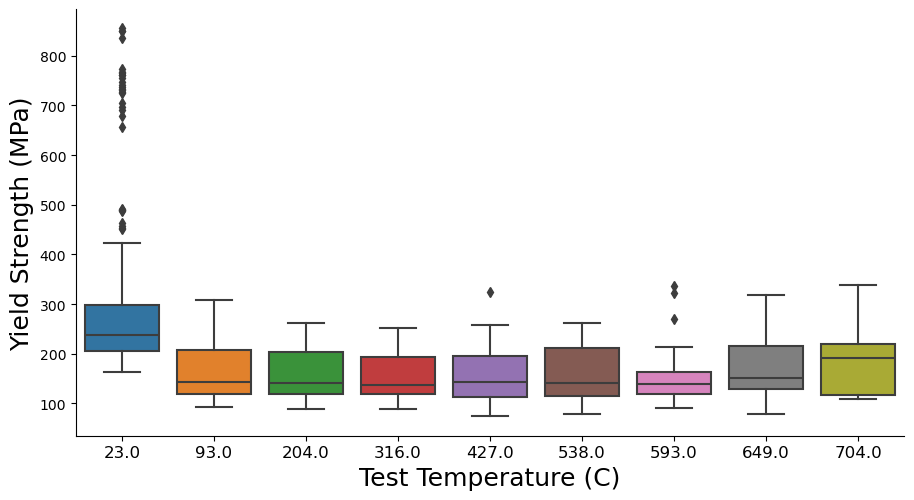

In [36]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
# increase the width of the figure, the x-axis labels are not visible
g = sns.catplot(x='Test Temperature (C)', y='Yield Strength (MPa)', data=temp_df_temperature, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(10)

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Test Temperature (C)', fontsize=18)
    ax.set_ylabel('Yield Strength (MPa)', fontsize=18)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=12)

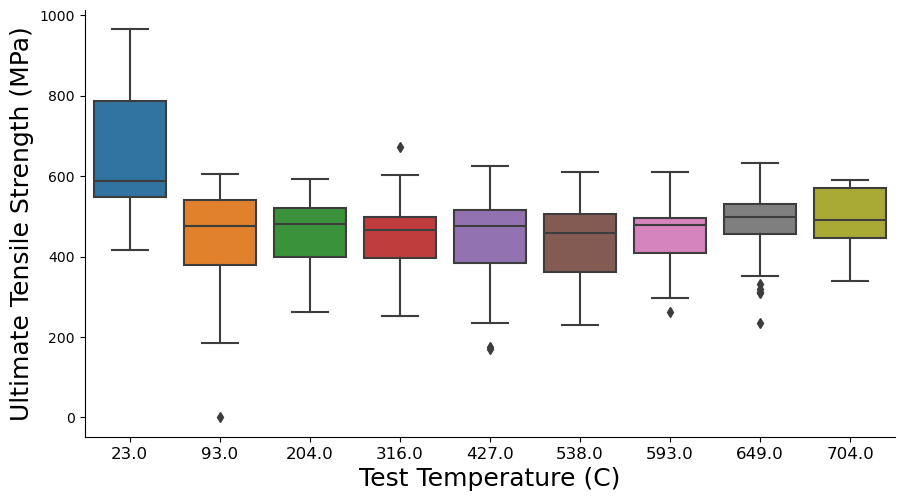

In [37]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Ultimate Tensile Strength (MPa)', data=temp_df_temperature, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(10)

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Test Temperature (C)', fontsize=18)
    ax.set_ylabel('Ultimate Tensile Strength (MPa)', fontsize=18)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=12)

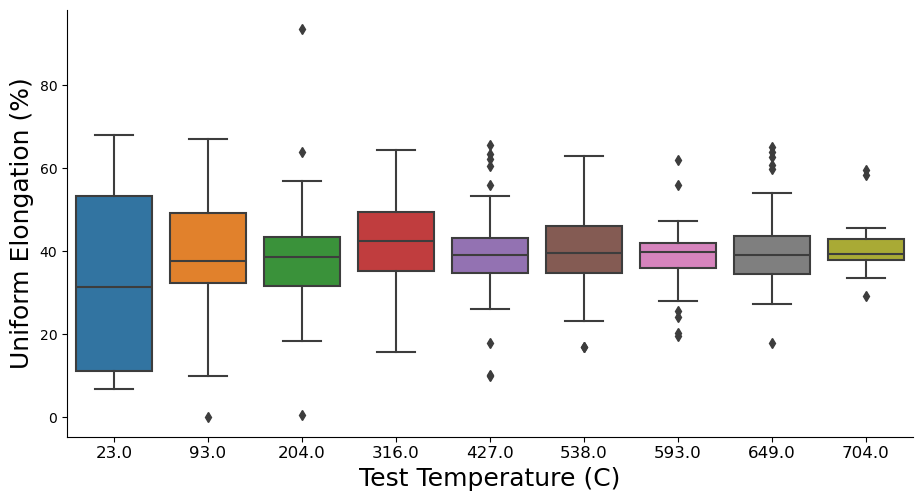

In [38]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Uniform Elongation (%)', data=temp_df_temperature, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(10)

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Test Temperature (C)', fontsize=18)
    ax.set_ylabel('Uniform Elongation (%)', fontsize=18)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=12)

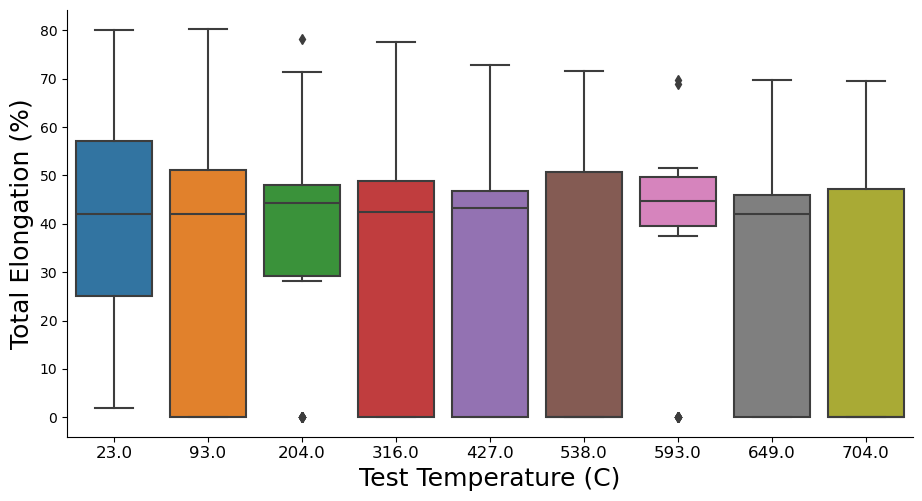

In [39]:
# plot total elongation box plots based on gauge length by treatment, create three subplots based on treatment
g = sns.catplot(x='Test Temperature (C)', y='Total Elongation (%)', data=temp_df_temperature, kind='box', palette='tab10', legend=False)
g.fig.set_figwidth(10)

# Increase the font size of the axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Test Temperature (C)', fontsize=18)
    ax.set_ylabel('Total Elongation (%)', fontsize=18)
# Increase the font size of the tick labels
g.set_xticklabels(fontsize=12)